In [1]:
data_root = (r"augmented\augmented")

In [ ]:
pip install protobuf==3.20.*

Note: you may need to restart the kernel to use updated packages.


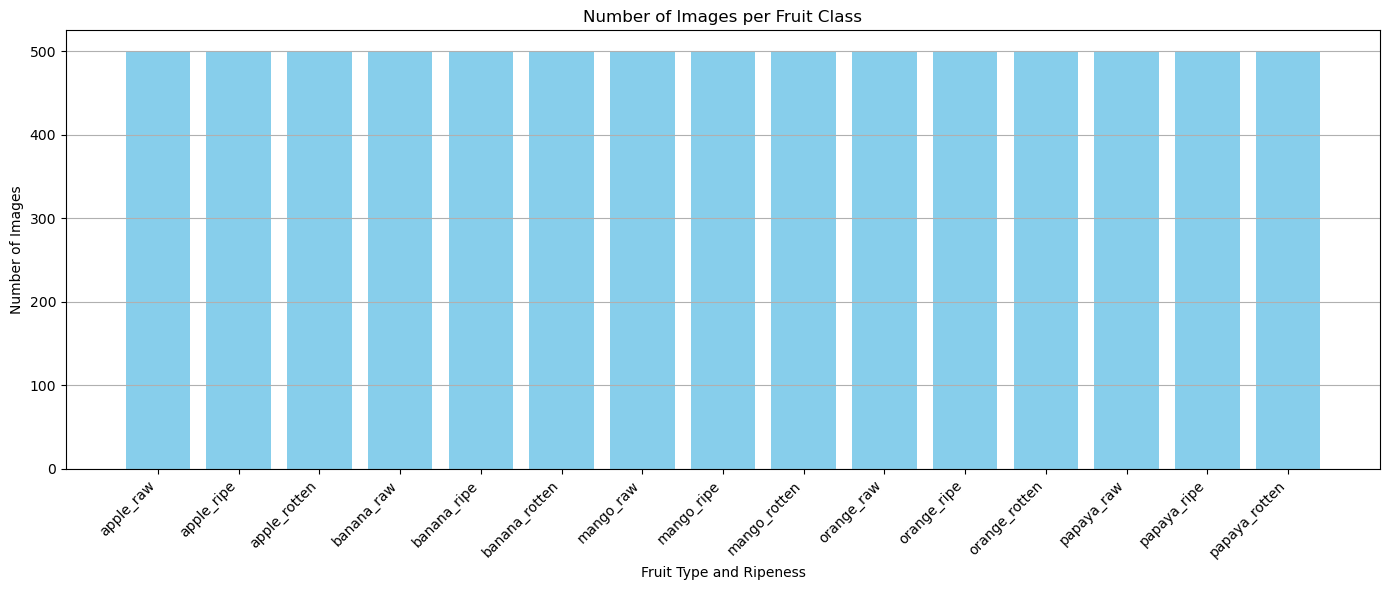

In [28]:
import os
import matplotlib.pyplot as plt

# Replace this path with your actual dataset path
dataset_path = data_root

# Count images in each subfolder (i.e., class)
fruit_counts = {}
for fruit_class in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, fruit_class)
    if os.path.isdir(class_path):
        image_count = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        fruit_counts[fruit_class] = image_count

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(fruit_counts.keys(), fruit_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Fruit Type and Ripeness")
plt.ylabel("Number of Images")
plt.title("Number of Images per Fruit Class")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [2]:
import tensorflow as tf
import numpy as np

In [3]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 1500 images belonging to 15 classes.
Found 6000 images belonging to 15 classes.


In [4]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 15))

In [5]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'apple_raw': 0, 'apple_ripe': 1, 'apple_rotten': 2, 'banana_raw': 3, 'banana_ripe': 4, 'banana_rotten': 5, 'mango_raw': 6, 'mango_ripe': 7, 'mango_rotten': 8, 'orange_raw': 9, 'orange_ripe': 10, 'orange_rotten': 11, 'papaya_raw': 12, 'papaya_ripe': 13, 'papaya_rotten': 14}


In [6]:
!type labels.txt

apple_raw
apple_ripe
apple_rotten
banana_raw
banana_ripe
banana_rotten
mango_raw
mango_ripe
mango_rotten
orange_raw
orange_ripe
orange_rotten
papaya_raw
papaya_ripe
papaya_rotten


In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)
15
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\Tanisha\AppData\Local\Temp\ipykernel_2496\3579435288.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


In [9]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [11]:
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
val_steps_per_epoch = int(np.ceil(valid_generator.samples / valid_generator.batch_size))

hist = model.fit(
    train_generator, 
    epochs=5, 
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch
).history


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 63s 334ms/step - accuracy: 0.9544 - loss: 0.1461 - val_accuracy: 0.9133 - val_loss: 0.2911
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 330ms/step - accuracy: 0.9692 - loss: 0.1035 - val_accuracy: 0.9520 - val_loss: 0.1524
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.9754 - loss: 0.0738 - val_accuracy: 0.9507 - val_loss: 0.1651
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - accuracy: 0.9776 - loss: 0.0627 - val_accuracy: 0.9500 - val_loss: 0.1840
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 330ms/step - accuracy: 0.9826 - loss: 0.0490 - val_accuracy: 0.9327 - val_loss: 0.2304


In [12]:
 for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_layer_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_rel

In [13]:
for layer in model.layers[:125]:
   layer.trainable = False
for layer in model.layers[125:]:
   layer.trainable = True

In [14]:
from tensorflow.keras.optimizers import SGD

model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),  # Use 'learning_rate' instead of 'lr'
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=5,                # Stop after 5 epochs with no improvement
    restore_best_weights=True # Revert to the best weights
)

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size).astype(int)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size).astype(int)

hist = model.fit(
    train_generator,
    epochs=81,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stop]    # Include the early stopping callback
).history


Epoch 1/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 90s 419ms/step - accuracy: 0.8309 - loss: 0.6006 - val_accuracy: 0.9167 - val_loss: 0.2744
Epoch 2/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 398ms/step - accuracy: 0.9669 - loss: 0.0967 - val_accuracy: 0.9320 - val_loss: 0.2043
Epoch 3/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 395ms/step - accuracy: 0.9789 - loss: 0.0655 - val_accuracy: 0.9467 - val_loss: 0.1736
Epoch 4/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 390ms/step - accuracy: 0.9821 - loss: 0.0582 - val_accuracy: 0.9553 - val_loss: 0.1495
Epoch 5/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 403ms/step - accuracy: 0.9875 - loss: 0.0440 - val_accuracy: 0.9593 - val_loss: 0.1323
Epoch 6/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 383ms/step - accuracy: 0.9864 - loss: 0.0410 - val_accuracy: 0.9600 - val_loss: 0.1308
Epoch 7/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 387ms/step - accuracy: 0.9873 - loss: 0.0415 - val_accuracy: 0.9593 - val_loss: 0.1227
Epoch 8/81
188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 409ms/step - accuracy: 0.9898 - loss: 0

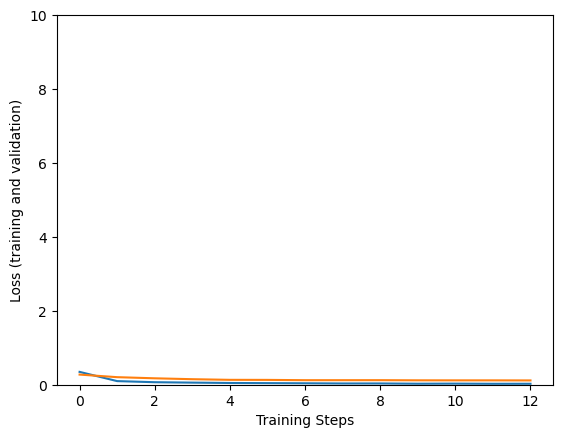

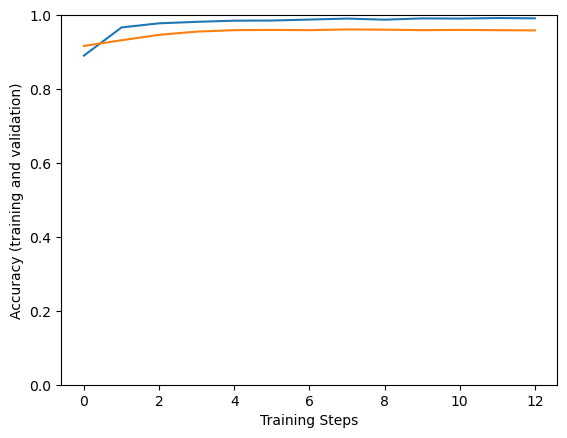

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,10])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [17]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [18]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Apple_Raw' 'Apple_Ripe' 'Apple_Rotten' 'Banana_Raw' 'Banana_Ripe'
 'Banana_Rotten' 'Mango_Raw' 'Mango_Ripe' 'Mango_Rotten' 'Orange_Raw'
 'Orange_Ripe' 'Orange_Rotten' 'Papaya_Raw' 'Papaya_Ripe' 'Papaya_Rotten']


In [19]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction results shape: (32, 15)


In [20]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Papaya_Raw' 'Orange_Rotten' 'Orange_Raw' 'Banana_Raw' 'Papaya_Raw'
 'Orange_Ripe' 'Orange_Raw' 'Banana_Ripe' 'Mango_Rotten' 'Banana_Raw'
 'Orange_Rotten' 'Banana_Ripe' 'Banana_Ripe' 'Mango_Ripe' 'Mango_Raw'
 'Banana_Rotten' 'Banana_Raw' 'Papaya_Rotten' 'Apple_Rotten' 'Banana_Ripe'
 'Apple_Ripe' 'Apple_Raw' 'Mango_Raw' 'Papaya_Ripe' 'Mango_Rotten'
 'Papaya_Ripe' 'Papaya_Rotten' 'Papaya_Ripe' 'Banana_Raw' 'Apple_Rotten'
 'Orange_Ripe' 'Orange_Ripe']


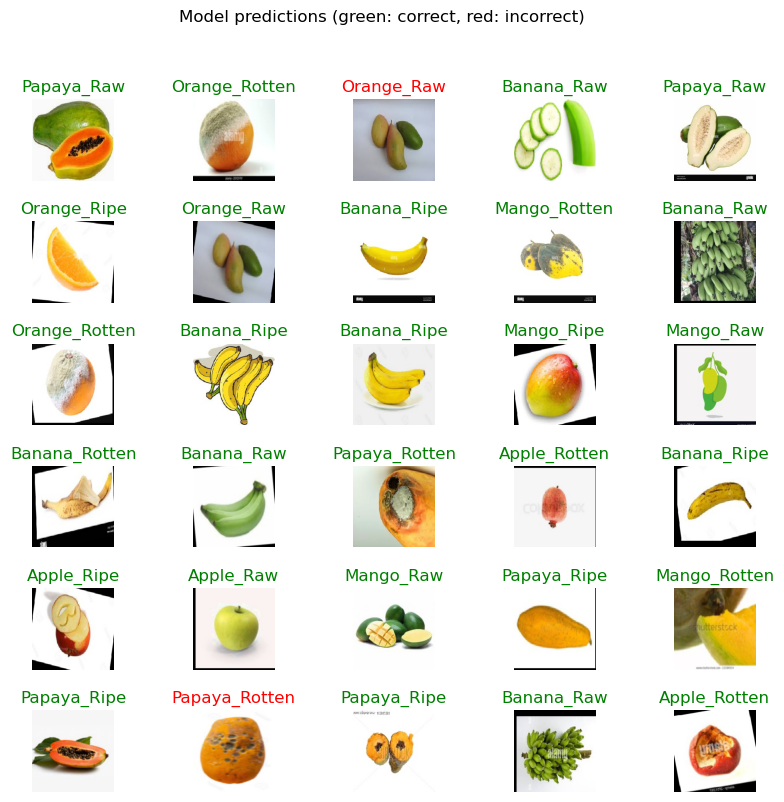

In [21]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [22]:
correct_predictions = np.sum(np.array(predicted_ids) == np.array(true_label_ids))
total_predictions = len(predicted_ids)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

Accuracy: 93.75%


<Figure size 1200x1000 with 0 Axes>

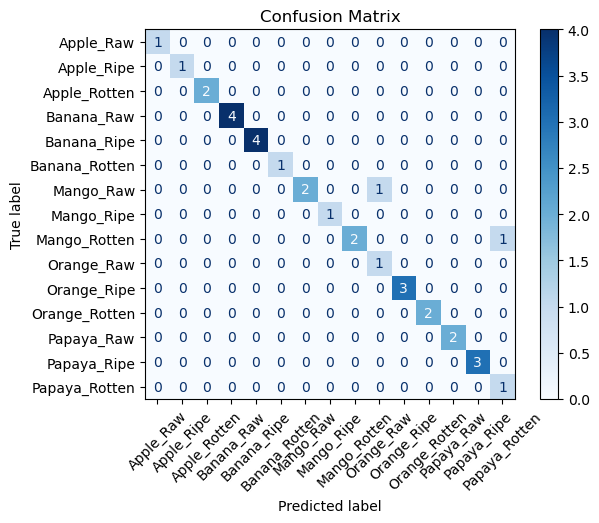

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(true_label_ids, predicted_ids)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_labels)

plt.figure(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [23]:
model.save('FR4model.keras')  


In [24]:
model.save('FR4model.h5')

In [32]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tensorflow.keras.preprocessing import image
from difflib import get_close_matches


In [33]:

# === CONFIGURATION ===
IMAGE_SIZE = (224, 224)
FRUIT_MODEL_PATH = "FR4model.keras"
LABELS_PATH = "labels.txt"
CSV_PATH = r"receipe.csv"
API_KEY = "62a1cb55dab2e669bff53381b95e6649"  # OpenWeather API key


In [34]:

# === STATE AVERAGE TEMPERATURES DATASET ===
state_avg_temps = {
    "Andaman and Nicobar Islands": 27.24,
    "Andhra Pradesh": 28.10,
    "Arunachal Pradesh": 19.26,
    "Assam": 23.48,
    "Bihar": 25.64,
    "Chandigarh": 23.59,
    "Chhattisgarh": 26.18,
    "Dadra and Nagar Haveli": 26.99,
    "Daman and Diu": 27.33,
    "Delhi": 25.48,
    "Goa": 26.66,
    "Gujarat": 27.35,
    "Haryana": 25.28,
    "Himachal Pradesh": 8.78,
    "Jammu and Kashmir": 3.22,
    "Jharkhand": 25.27,
    "Karnataka": 26.04,
    "Kerala": 26.45,
    "Lakshadweep": 27.79,
    "Madhya Pradesh": 25.95,
    "Maharashtra": 26.88,
    "Manipur": 20.54,
    "Meghalaya": 22.24,
    "Mizoram": 22.70,
    "Nagaland": 20.00,
    "Odisha": 26.22,
    "Puducherry": 28.89,
    "Punjab": 24.36,
    "Rajasthan": 26.27,
    "Sikkim": 6.00,
    "Tamil Nadu": 27.72,
    "Telangana": 27.82,
    "Tripura": 25.11,
    "Uttar Pradesh": 25.91,
    "Uttarakhand": 14.06,
    "West Bengal": 25.93
}


In [35]:

# === LOAD MODEL AND LABELS ===
try:
    fruit_ripeness_model = tf.keras.models.load_model(FRUIT_MODEL_PATH)
    print("✅ Model loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

try:
    with open(LABELS_PATH, 'r') as f:
        class_names = [line.strip().title() for line in f.readlines()]
    print(f"✅ Loaded {len(class_names)} labels")
except Exception as e:
    print(f"❌ Error loading labels: {e}")
    exit()



✅ Model loaded successfully
✅ Loaded 15 labels


In [36]:
# === RECIPE DATASET HANDLING ===
def load_recipe_data():
    try:
        # First, read the CSV to determine its structure
        df = pd.read_csv(CSV_PATH)
        
        # Check if the necessary columns exist, if not create them
        required_columns = ['fruit_type', 'season', 'temperature', 'weather', 
                           'dish_type', 'preferred_dish_name', 'fruit_condition']
        
        for col in required_columns:
            if col not in df.columns:
                df[col] = ""  # Add empty column if missing
        
        # Clean all string columns
        str_cols = df.select_dtypes(include=['object']).columns
        df[str_cols] = df[str_cols].apply(lambda x: x.str.lower().str.strip())
        
        # Create a default dataset if the CSV is empty or couldn't be loaded properly
        if df.empty:
            print("Creating default recipe dataset...")
            data = {
                'fruit_type': ['banana', 'banana', 'banana', 'apple', 'apple', 'apple',
                              'mango', 'mango', 'mango', 'orange', 'orange', 'orange'],
                'season': ['all', 'all', 'all', 'all', 'all', 'all', 
                          'all', 'all', 'all', 'all', 'all', 'all'],
                'temperature': ['hot', 'cold', 'moderate', 'hot', 'cold', 'moderate',
                               'hot', 'cold', 'moderate', 'hot', 'cold', 'moderate'],
                'weather': ['humid', 'humid', 'humid', 'dry', 'rainy', 'sunny',
                           'humid', 'rainy', 'sunny', 'dry', 'rainy', 'sunny'],
                'dish_type': ['snack', 'drink', 'dessert', 'snack', 'dessert', 'salad',
                             'dessert', 'drink', 'fresh', 'juice', 'dessert', 'salad'],
                'preferred_dish_name': ['banana chips', 'banana smoothie', 'banana pudding',
                                       'baked apple', 'apple pie', 'apple salad',
                                       'mango ice cream', 'mango milkshake', 'fresh mango',
                                       'orange juice', 'orange cake', 'orange salad'],
                'fruit_condition': ['unripe', 'ripe', 'overripe', 'ripe', 'overripe', 'ripe',
                                   'ripe', 'ripe', 'ripe', 'ripe', 'overripe', 'ripe']
            }
            df = pd.DataFrame(data)
        
        return df
    except Exception as e:
        print(f"❌ Error loading recipe data: {e}")
        # Create a minimum default dataset
        data = {
            'fruit_type': ['banana', 'banana', 'banana', 'apple', 'apple'],
            'season': ['all', 'all', 'all', 'all', 'all'],
            'temperature': ['hot', 'cold', 'moderate', 'hot', 'cold'],
            'weather': ['humid', 'humid', 'humid', 'dry', 'rainy'],
            'dish_type': ['snack', 'drink', 'dessert', 'snack', 'dessert'],
            'preferred_dish_name': ['banana chips', 'banana smoothie', 'banana pudding',
                                  'baked apple', 'apple pie'],
            'fruit_condition': ['unripe', 'ripe', 'overripe', 'ripe', 'overripe']
        }
        return pd.DataFrame(data)

recipe_df = load_recipe_data()
print(f"📊 Loaded {len(recipe_df)} recipes")


❌ Error loading recipe data: [Errno 2] No such file or directory: 'receipe.csv'
📊 Loaded 5 recipes


In [37]:

# === FUZZY TEMPERATURE LOGIC ===
def compute_membership(diff):
    scores = {'cold': 0.0, 'cool': 0.0, 'moderate': 0.0, 'warm': 0.0, 'hot': 0.0}

    # Cold: ≤ -6 (1.0), fades to 0 at -4
    if diff <= -6:
        scores['cold'] = 1.0
    elif -6 < diff <= -4:
        scores['cold'] = (-4 - diff) / 2  # 1.0 at -6 → 0.0 at -4

    # Cool: peaks at -4 (1.0), spans -6 to 0 (overlaps Mild)
    if -6 <= diff <= -4:
        scores['cool'] = (diff + 6) / 2  # 0.0→1.0 (-6 to -4)
    elif -4 < diff <= 0:
        scores['cool'] = (-diff) / 4      # 1.0→0.0 (-4 to 0)

    # Moderate: peaks at 0 (1.0), spans -4 to +4 (overlaps Cool & Warm)
    if -4 <= diff <= 0:
        scores['moderate'] = (diff + 4) / 4   # 0.0→1.0 (-4 to 0)
    elif 0 < diff <= 4:
        scores['moderate'] = (4 - diff) / 4    # 1.0→0.0 (0 to +4)

    # Warm: peaks at +4 (1.0), spans 0 to +6 (overlaps Mild & Hot)
    if 0 <= diff <= 4:
        scores['warm'] = diff / 4          # 0.0→1.0 (0 to +4)
    elif 4 < diff <= 6:
        scores['warm'] = (6 - diff) / 2    # 1.0→0.0 (+4 to +6)

    # Hot: ≥ +6 (1.0), starts at +4 (overlaps Warm)
    if 4 <= diff < 6:
        scores['hot'] = (diff - 4) / 2    # 0.0→1.0 (+4 to +6)
    elif diff >= 6:
        scores['hot'] = 1.0

    return scores


In [38]:

def fuzzy_label_from_scores(scores):
    return max(scores, key=scores.get)

def adaptive_temp_label(state, temp_celsius):
    avg = state_avg_temps.get(state)
    if avg is None:
        return "moderate", 0, {"moderate": 1.0}  # Default fallback
    
    diff = temp_celsius - avg
    scores = compute_membership(diff)
    return fuzzy_label_from_scores(scores), diff, scores

def get_location():
    try:
        response = requests.get('https://ipinfo.io/json', timeout=5)
        data = response.json()
        city = data.get('city', 'Unknown')
        region = data.get('region', 'Delhi')  # Default to Delhi if unknown
        loc = data.get('loc', '28.6139,77.2090')  # Default to Delhi coords
        return loc, city, region
    except Exception as e:
        print(f"⚠️ Location detection error: {e}")
        return "28.6139,77.2090", "Unknown", "Delhi"  # Default fallback

def get_temperature(lat, lon, api_key):
    try:
        url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}&units=metric"
        response = requests.get(url, timeout=5)
        data = response.json()
        temp = data['main']['temp']
        weather = data['weather'][0]['main'].lower()
        return temp, weather
    except Exception as e:
        print(f"⚠️ Weather API error: {e}")
        return 25, "clear"  # Default fallback

def plot_membership(scores):
    plt.figure(figsize=(8, 4))
    labels = list(scores.keys())
    values = list(scores.values())
    plt.bar(labels, values, color='skyblue')
    plt.ylim(0, 1.1)
    plt.title("Temperature Classification")
    plt.xlabel("Temperature Category")
    plt.ylabel("Membership Score")
    plt.grid(True, axis='y')
    plt.show()


In [39]:

# === IMPROVED RECIPE RECOMMENDER ===
def recommend_recipe(fruit_type, fruit_condition, temperature, weather):
    # Normalize inputs
    fruit_type = fruit_type.lower().strip()
    fruit_condition = fruit_condition.lower().strip()
    temperature = temperature.lower().strip()
    weather = weather.lower().strip()
    #temperature = temperature.lower().strip()
    #weather = weather.lower().strip()

    print("\n🔍 Searching recipes for:")
    print(f"  Fruit: {fruit_type.title()} ({fruit_condition})")
    print(f"  Weather: {weather.title()}, {temperature.title()}")

    # Check for exact match first
    exact_match = recipe_df[
        (recipe_df['fruit_type'] == fruit_type) &
        (recipe_df['fruit_condition'] == fruit_condition) &
        (recipe_df['temperature'] == temperature) &
        (recipe_df['weather'] == weather)
    ]

    if not exact_match.empty:
        dish = exact_match.sample(1).iloc[0]['preferred_dish_name'].title()
        print(f"✅ Found perfect match!")
        return dish

    # Find most similar match using a scoring system
    def similarity_score(row):
        score = 0
        # Fruit type is most important
        if row['fruit_type'] == fruit_type:
            score += 10
        # Fruit condition is next most important
        if row['fruit_condition'] == fruit_condition:
            score += 5
        elif row['fruit_condition'] == 'all':
            score += 3
        # Temperature and weather are less important
        if row['temperature'] == temperature:
            score += 2
        if row['weather'] == weather:
            score += 2
        return score

    # Apply scoring to all recipes
    recipe_df['score'] = recipe_df.apply(similarity_score, axis=1)
    
    # Get the best matches
    best_matches = recipe_df[recipe_df['score'] > 0].sort_values('score', ascending=False)
    
    if not best_matches.empty:
        top_match = best_matches.iloc[0]
        dish = top_match['preferred_dish_name'].title()
        print(f"⚠️ Found most similar match (similarity score: {top_match['score']})")
        return dish

    # Ultimate fallback
    generic_suggestions = {
        'unripe': 'make chips or cook as vegetable',
        'ripe': 'eat fresh or make smoothie',
        'overripe': 'use in baking or pudding'
    }
    suggestion = generic_suggestions.get(fruit_condition, 'use in cooking')
    return f"{suggestion.title()} (no specific recipe found)"


In [40]:

# === IMAGE PREDICTION === (REPLACED AS REQUESTED)
def predict_fruit_and_ripeness(image_path):
    try:
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=IMAGE_SIZE)
        img_array = image.img_to_array(img) / 255.0
        img_batch = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = fruit_ripeness_model.predict(img_batch)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        predicted_class = class_names[predicted_class_index]
        confidence = prediction[0][predicted_class_index]

        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"{predicted_class} ({confidence * 100:.2f}%)", pad=20)
        plt.axis('off')
        plt.show()

        # Parse the label
        if '_' in predicted_class:
            parts = predicted_class.split('_')
            fruit = parts[0].lower()
            condition = parts[1].lower() if len(parts) > 1 else 'ripe'
        else:
            # Unexpected format, split by whitespace as fallback
            parts = predicted_class.split()
            if len(parts) > 1:
                fruit = parts[0].lower()
                condition = parts[1].lower()
            else:
                fruit = predicted_class.lower()
                condition = 'ripe'  # Default

        # Display detection results separately as requested
        print(f"\n🔍 Model prediction: {predicted_class}")
        print(f"🍓 Detected fruit type: {fruit.title()}")
        print(f"🥝 Detected fruit condition: {condition}")
        
        return fruit, condition

    except Exception as e:
        print(f"❌ Image processing error: {e}")
        return None, None


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get unique class indices actually present in your validation labels
unique_labels = np.unique(true_label_ids)

# Use only the matching class names
matched_class_labels = [list(valid_generator.class_indices.keys())[i] for i in unique_labels]

# Now generate the classification report with matching labels and names
report = classification_report(
    true_label_ids,
    predicted_ids,
    labels=unique_labels,
    target_names=matched_class_labels,
    digits=2
)

print("Classification Report:\n")
print(report)

Classification Report:

               precision    recall  f1-score   support

    apple_raw       1.00      1.00      1.00         1
 apple_rotten       0.75      1.00      0.86         3
   banana_raw       1.00      1.00      1.00         2
  banana_ripe       1.00      1.00      1.00         4
banana_rotten       1.00      1.00      1.00         1
    mango_raw       0.75      1.00      0.86         3
   mango_ripe       1.00      1.00      1.00         4
 mango_rotten       0.67      1.00      0.80         2
   orange_raw       1.00      1.00      1.00         2
orange_rotten       1.00      1.00      1.00         1
   papaya_raw       1.00      0.67      0.80         3
  papaya_ripe       1.00      0.67      0.80         3
papaya_rotten       1.00      0.67      0.80         3

     accuracy                           0.91        32
    macro avg       0.94      0.92      0.92        32
 weighted avg       0.93      0.91      0.90        32



: 

In [41]:

# === WEATHER INPUT WITH AUTOMATIC OR MANUAL OPTIONS ===
def get_weather_input(default = 1):
    print("\n" + "-"*40)
    print(" WEATHER CONDITIONS ".center(40))
    print("-"*40)
    
    print("\nHow would you like to provide weather information?")
    print("1. Detect automatically (requires internet)")
    print("2. Enter manually")
    
    #choice = input("Your choice (1/2): ").strip()
    
    if default:
        try:
            print("\n🔍 Detecting your location and weather...")
            location, city, region = get_location()
            lat, lon = map(float, location.split(','))
            temperature, weather_condition = get_temperature(lat, lon, API_KEY)
            
            print(f"📍 Location detected: {city}, {region}")
            print(f"🌡️ Current temperature: {temperature:.1f}°C")
            print(f"☁️ Current weather: {weather_condition.title()}")
            
            temp_label, diff, scores = adaptive_temp_label(region, temperature)
            
            print(f"📊 Temperature deviation from regional average: {diff:.1f}°C")
            print(f"🔍 Adaptive temperature classification: {temp_label.title()}")
            
            # Plot the fuzzy membership scores
            plot_membership(scores)
            
            return temp_label, weather_condition
            
        except Exception as e:
            print(f"⚠️ Error in automatic detection: {e}")
            print("Switching to manual input...")
            return get_manual_weather_input()
    else:
        return get_manual_weather_input()

def get_manual_weather_input():
    while True:
        try:
            degree = float(input("\nEnter current temperature in °C: "))
            break
        except ValueError:
            print("⚠️ Please enter a valid number (e.g., 23.5)")
    
    state = input("Enter your state (for temperature context): ").strip()
    
    if state in state_avg_temps:
        temp_label, diff, scores = adaptive_temp_label(state, degree)
        print(f"📊 Temperature deviation from state average: {diff:.1f}°C")
        print(f"🔍 Adaptive temperature classification: {temp_label.title()}")
        plot_membership(scores)
    else:
        # Simple fallback if state not in dataset
        if degree <= 15:
            temp_label = "cold"
        elif degree <= 25:
            temp_label = "moderate"
        else:
            temp_label = "hot"
        print(f"🔍 Temperature classified as: {temp_label.title()}")
    
    weather = input("Weather Condition (Sunny/Rainy/Humid/etc): ").strip().lower()
    return temp_label, weather


In [42]:

# === MAIN USER FLOW ===
def main_flow():
    print("\n" + "="*40)
    print(" FRUIT RECIPE RECOMMENDER ".center(40))
    print("="*40)

    # Step 1: Get fruit information
    print("\nHow would you like to provide fruit information?")
    print("1. Upload an image")
    print("2. Enter details manually")

    fruit = None
    condition = None
    
    while True:
        choice = input("\nYour choice (1/2): ").strip()

        if choice == '1':
            image_path = input("\nEnter image path: ").strip()
            fruit, condition = predict_fruit_and_ripeness(image_path)
            if not fruit:
                print("⚠️ Switching to manual input")
                fruit = input("\nEnter fruit type: ").strip().lower()
                condition = input("Enter fruit condition (unripe/ripe/overripe): ").strip().lower()
            break

        elif choice == '2':
            fruit = input("\nEnter fruit type: ").strip().lower()
            condition = input("Enter fruit condition (unripe/ripe/overripe): ").strip().lower()
            break

        else:
            print("Invalid choice. Please enter 1 or 2")

    # Step 2: Get weather information
    temp, weather = get_weather_input()

    # Step 3: Get recommendation using the gathered information
    recommendation = recommend_recipe(fruit, condition, temp, weather)

    # Display results
    print("\n" + "="*40)
    print(" RECOMMENDATION ".center(40, "★"))
    print("="*40)
    print(f"\nFor {condition} {fruit} in {weather}, {temp} weather:")
    print(f"\n✨ {recommendation}")

    # Show related recipes
    related = recipe_df[recipe_df['fruit_type'] == fruit]
    if not related.empty and len(related) > 1:
        print("\n📚 Other recipes for this fruit:")
        related_display = related[['fruit_condition', 'preferred_dish_name']].copy()
        related_display['preferred_dish_name'] = related_display['preferred_dish_name'].str.title()
        related_display['fruit_condition'] = related_display['fruit_condition'].str.title()
        print(related_display.to_string(index=False))




        FRUIT RECIPE RECOMMENDER        

How would you like to provide fruit information?
1. Upload an image
2. Enter details manually
Invalid choice. Please enter 1 or 2
Invalid choice. Please enter 1 or 2
Invalid choice. Please enter 1 or 2
Invalid choice. Please enter 1 or 2
Invalid choice. Please enter 1 or 2
Invalid choice. Please enter 1 or 2
Invalid choice. Please enter 1 or 2
❌ Image processing error: [Errno 2] No such file or directory: '1'
⚠️ Switching to manual input

----------------------------------------
           WEATHER CONDITIONS           
----------------------------------------

How would you like to provide weather information?
1. Detect automatically (requires internet)
2. Enter manually

🔍 Detecting your location and weather...
⚠️ Location detection error: HTTPSConnectionPool(host='ipinfo.io', port=443): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C7308EE210>: Failed to establish a 

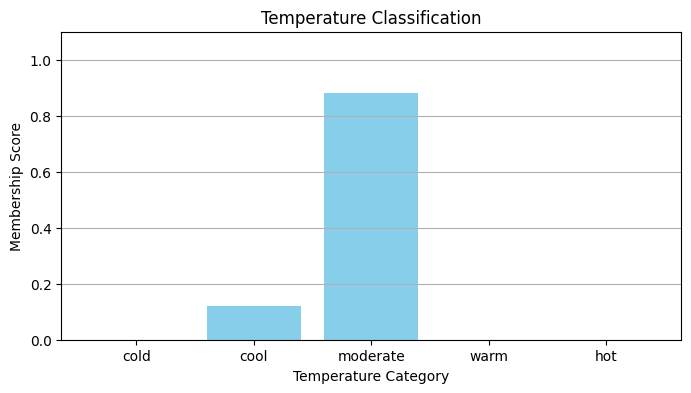


🔍 Searching recipes for:
  Fruit: 1 (1)
  Weather: Clear, Moderate
⚠️ Found most similar match (similarity score: 2)

★★★★★★★★★★★★ RECOMMENDATION ★★★★★★★★★★★★

For 1 1 in clear, moderate weather:

✨ Banana Pudding

Happy cooking! 👨‍🍳


In [43]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    while True:
        main_flow()
        if input("\nTry another? (y/n): ").lower() != 'y':
            print("\nHappy cooking! 👨‍🍳")
            break

In [44]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import threading
import os
import io

# Your full imports and functions go here
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tensorflow.keras.preprocessing import image
from difflib import get_close_matches
from io import BytesIO

# === Include your constants and functions here ===
# (Paste your entire config, temp logic, recipe loading, etc.)
# Just include everything from IMAGE_SIZE to plot_membership.

# UI STARTS HERE
class FruitSnapApp:
    def __init__(self, root):
        self.root = root
        self.root.title("FruitSnap 🍓📸 - Smart Fruit Classifier")

        self.label = Label(root, text="Upload a fruit image to get started!", font=("Arial", 14))
        self.label.pack(pady=10)

        self.upload_btn = Button(root, text="Upload Image", command=self.upload_image)
        self.upload_btn.pack(pady=5)

        self.result_label = Label(root, text="", font=("Arial", 12), wraplength=500, justify='left')
        self.result_label.pack(pady=10)

        self.canvas = tk.Canvas(root, width=300, height=300)
        self.canvas.pack()

    def upload_image(self):
        filepath = filedialog.askopenfilename()
        if not filepath:
            return

        self.label.config(text="⏳ Processing image...")
        self.result_label.config(text="")
        threading.Thread(target=self.process_image, args=(filepath,)).start()

    def process_image(self, path):
        try:
            # Load and show image
            img = Image.open(path)
            img.thumbnail((300, 300))
            img_tk = ImageTk.PhotoImage(img)
            self.canvas.create_image(150, 150, image=img_tk)
            self.canvas.image = img_tk

            # Preprocess for model
            img_model = image.load_img(path, target_size=IMAGE_SIZE)
            x = image.img_to_array(img_model) / 255.0
            x = np.expand_dims(x, axis=0)

            pred = fruit_ripeness_model.predict(x)
            pred_index = np.argmax(pred)
            predicted_class = class_names[pred_index]
            fruit_name, fruit_state = predicted_class.split("_")

            # Location & weather
            loc, city, region = get_location()
            lat, lon = loc.split(",")
            temp, weather = get_weather_input(1)
            temp_label, diff, scores = adaptive_temp_label(region, temp)

            print(fruit_name)
            print(fruit_state)

            recommendation = recommend_recipe(fruit_name, fruit_state,temp,weather)

            result_text = (
                f"📍 Location: {city}, {region}\n"
                f"🌡️ Temp: {temp:.1f}°C ({temp_label})\n"
                f"🌤️ Weather: {weather.title()}\n\n"
                f"🍎 Detected: {fruit_name.title()} ({fruit_state.title()})\n"
                f"👨‍🍳 Recommended Dish: {recommendation}"
            )
            self.result_label.config(text=result_text)

            self.show_plot(scores)

        except Exception as e:
            self.result_label.config(text=f"❌ Error: {e}")

    def show_plot(self, scores):
        buf = BytesIO()
        plot_membership(scores)
        plt.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        img_plot = Image.open(buf)
        img_plot.thumbnail((300, 150))
        img_tk = ImageTk.PhotoImage(img_plot)
        self.canvas.create_image(150, 270, image=img_tk)
        self.canvas.image = img_tk

# Run app
if __name__ == "__main__":
    root = tk.Tk()
    app = FruitSnapApp(root)
    root.mainloop()


KeyboardInterrupt: 